# Calculate Preformed vs Regenerated Carbon. 
jml1@mit.edu 16-18 Oct Hackathon LDEO

This notebook processes just the `UKESM1-0-LL` model as it has both `o2` and `o2sat` variables, and checks the calculation of `o2sat` using the `gsw` package.

In [3]:
%matplotlib inline

import xarray as xr
import intake

import matplotlib.pyplot as plt
import numpy as np

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

Inject your `Dask` code here

In [4]:
from dask.distributed import Client

client = Client("tcp://10.32.15.116:35423")
client

Client Scheduler: tcp://10.32.15.116:35423 Dashboard: /user/0000-0002-2993-7484/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 11.50 GB


In [5]:
# Load collection

if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

pangeo-cmip6-ESM Collection with 28691 entries:
	> 10 activity_id(s)

	> 23 institution_id(s)

	> 48 source_id(s)

	> 29 experiment_id(s)

	> 86 member_id(s)

	> 23 table_id(s)

	> 190 variable_id(s)

	> 7 grid_label(s)

	> 28691 zstore(s)

	> 59 dcpp_init_year(s)

In [6]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year'],
      dtype='object')

In [7]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [9]:
cat = col.search(experiment_id='historical',
                 variable_id=['o2','o2sat','dissic'],
                 source_id=['UKESM1-0-LL'])
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':30}, 'decode_times': False})
model=dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [10]:
cat = col.search(experiment_id='historical',
                 variable_id=['so'],
                 source_id=['UKESM1-0-LL'])
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':30}, 'decode_times': False})
models=dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


In [11]:
cat = col.search(experiment_id='historical',
                 variable_id=['thetao'],
                 source_id=['UKESM1-0-LL'])
# Load the data
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time':30}, 'decode_times': False})
modelt=dset_dict['CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn']


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


Oh look, `O2` is on a slightly different grid to `thetao` and `so`!!!!! That's odd.


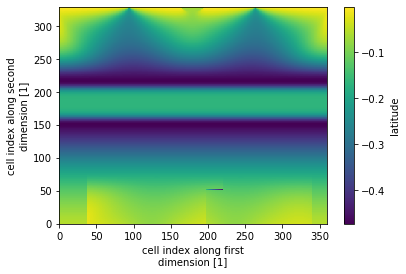

In [12]:
(model.latitude-modelt.latitude).plot()

Plot `o2`, `o2sat`, and Apparent Oxygen Utilization (although at the surface, it shows disequilibrium rather than biogenic consumption)

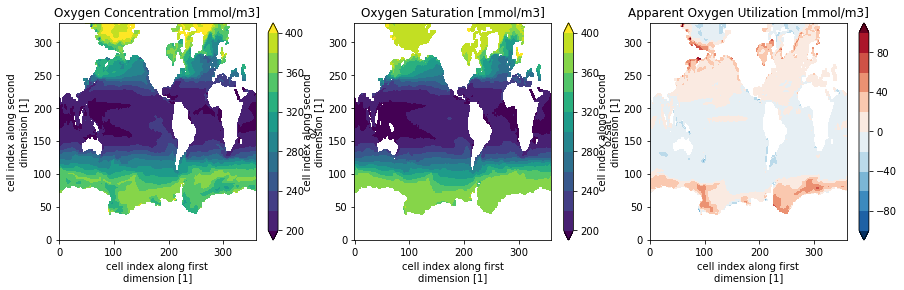

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(15,4),ncols=3,nrows=1)
(model.isel(time=-1).isel(lev=0).o2*1e3).plot(ax=ax1,levels=np.arange(200,420,20),extend="both")

# Looks like O2sat is 1000x too small! Maybe they doubley applied the mmol->mol conversion?
(model.isel(time=-1).isel(lev=0).o2sat*1e6).plot(ax=ax2,levels=np.arange(200,420,20),extend="both")
aou=(model.o2sat*1000-model.o2)
(aou.isel(time=-1).isel(lev=0)*1e3).plot(ax=ax3,levels=np.arange(-100,120,20),extend="both")

ax1.set_title("Oxygen Concentration [mmol/m3]")
ax2.set_title("Oxygen Saturation [mmol/m3]")
ax3.set_title("Apparent Oxygen Utilization [mmol/m3]")
plt.show()

Plot meridional sections in the Atlantic and Pacific

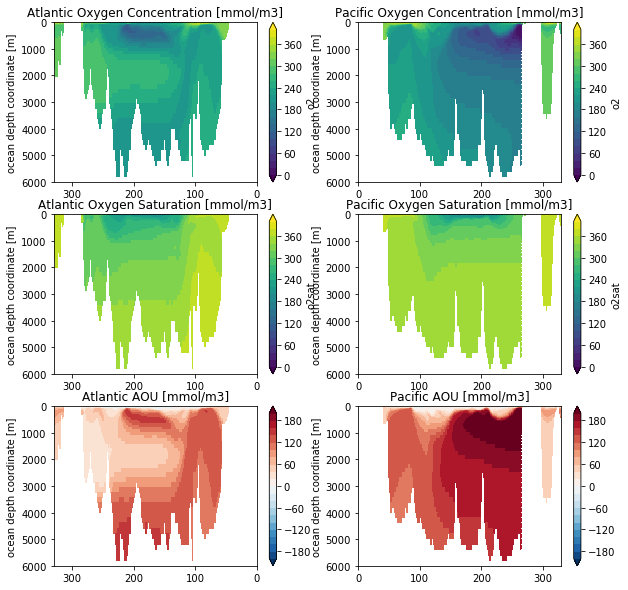

In [14]:
fig, (axes) = plt.subplots(figsize=(10,10),ncols=2,nrows=3)
(model.isel(time=-1).isel(i=255).o2*1e3).plot(ax=axes[0,0],levels=np.arange(0,420,20),extend="both")
(model.isel(time=-1).isel(i=125).o2*1e3).plot(ax=axes[0,1],levels=np.arange(0,420,20),extend="both")

# Looks like O2sat is 1000x too small! Maybe they doubley applied the mmol->mol conversion?
(model.isel(time=-1).isel(i=255).o2sat*1e6).plot(ax=axes[1,0],levels=np.arange(0,420,20),extend="both")
(model.isel(time=-1).isel(i=125).o2sat*1e6).plot(ax=axes[1,1],levels=np.arange(0,420,20),extend="both")

(aou.isel(time=-1).isel(i=255)*1e3).plot(ax=axes[2,0],levels=np.arange(-200,220,20),extend="both")
(aou.isel(time=-1).isel(i=125)*1e3).plot(ax=axes[2,1],levels=np.arange(-200,220,20),extend="both")

for jj in range(0,2):
    for ii in range(0,3):
        if jj==0:
            axes[ii,jj].set_xlim(330,0)
        axes[ii,jj].set_ylim(6000,0)
        axes[ii,jj].set_xlabel("")
        
axes[0,0].set_title("Atlantic Oxygen Concentration [mmol/m3]")
axes[0,1].set_title("Pacific Oxygen Concentration [mmol/m3]")
axes[1,0].set_title("Atlantic Oxygen Saturation [mmol/m3]")
axes[1,1].set_title("Pacific Oxygen Saturation [mmol/m3]")
axes[2,0].set_title("Atlantic AOU [mmol/m3]")
axes[2,1].set_title("Pacific AOU [mmol/m3]")
plt.show()

Derive Preformed and Regenerated carbon (assuming Redfield ratios), and plot Atlantic and Pacific sections

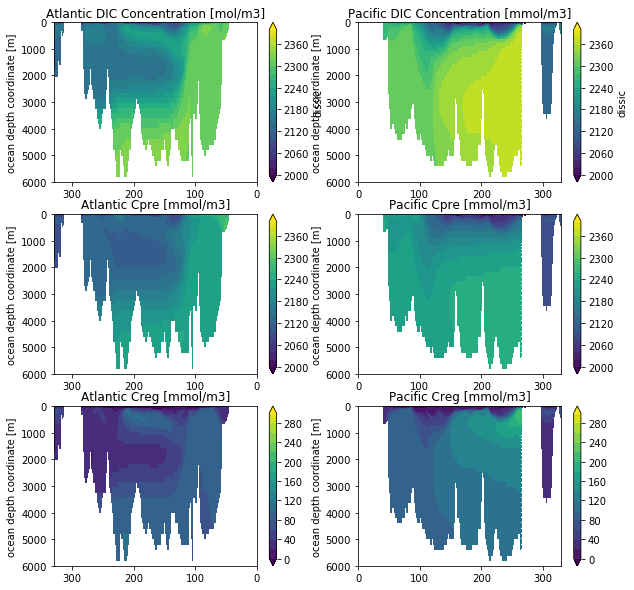

In [15]:
R_co=117/170

cpre=(model.dissic-aou*R_co)*1e3
creg=aou*R_co*1e3

fig, (axes) = plt.subplots(figsize=(10,10),ncols=2,nrows=3)
(model.isel(time=-1).isel(i=255).dissic*1e3).plot(ax=axes[0,0],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
(model.isel(time=-1).isel(i=125).dissic*1e3).plot(ax=axes[0,1],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")

(cpre.isel(time=-1).isel(i=255)).plot(ax=axes[1,0],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")
(cpre.isel(time=-1).isel(i=125)).plot(ax=axes[1,1],levels=np.arange(2000,2420,20),cmap='viridis',extend="both")

(creg.isel(time=-1).isel(i=255)).plot(ax=axes[2,0],levels=np.arange(0,320,20),cmap='viridis',extend="both")
(creg.isel(time=-1).isel(i=125)).plot(ax=axes[2,1],levels=np.arange(0,320,20),cmap='viridis',extend="both")

for jj in range(0,2):
    for ii in range(0,3):
        if jj==0:
            axes[ii,jj].set_xlim(330,0)
        axes[ii,jj].set_ylim(6000,0)
        axes[ii,jj].set_xlabel("")
        
axes[0,0].set_title("Atlantic DIC Concentration [mol/m3]")
axes[0,1].set_title("Pacific DIC Concentration [mmol/m3]")
axes[1,0].set_title("Atlantic Cpre [mmol/m3]")
axes[1,1].set_title("Pacific Cpre [mmol/m3]")
axes[2,0].set_title("Atlantic Creg [mmol/m3]")
axes[2,1].set_title("Pacific Creg [mmol/m3]")
plt.show()

# What about models that dont have o2sat? Can calculate using the GSW toolbox

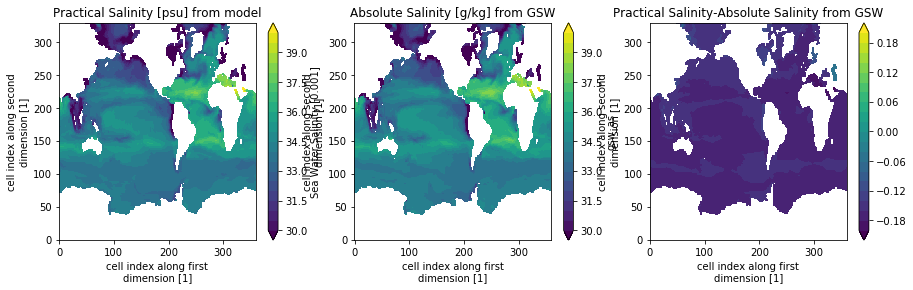

In [16]:
import gsw

#Calculate Absolute Salinity
models['gsw_as']=xr.apply_ufunc(gsw.SA_from_SP, models.so.isel(time=-1), models.lev, models.longitude, models.latitude, dask='allowed')

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(15,4),ncols=3,nrows=1)
(models.isel(time=-1).isel(lev=0).so).plot(ax=ax1,levels=np.arange(30,40.5,0.5),extend="both")
ax1.set_title("Practical Salinity [psu] from model")
(models.isel(lev=0).gsw_as).plot(ax=ax2,levels=np.arange(30,40.5,0.5),extend="both")
ax2.set_title("Absolute Salinity [g/kg] from GSW")
sanom=(models.so-models.gsw_as)
(sanom.isel(time=-1).isel(lev=0)).plot(ax=ax3,levels=np.arange(-0.2,0.220,0.020),extend="both")
ax3.set_title("Practical Salinity-Absolute Salinity from GSW")
plt.show()

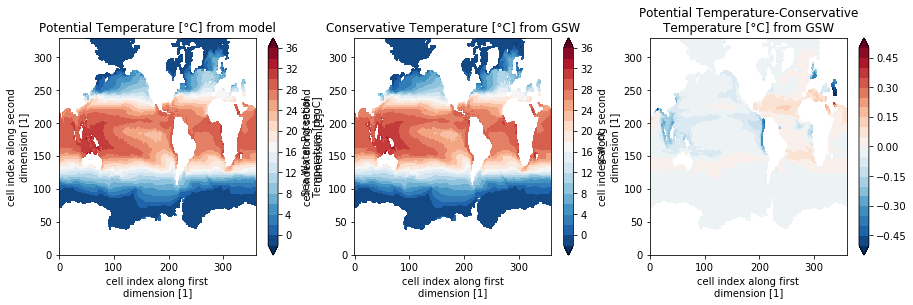

In [17]:
#Calculate Conservative Temperature

modelt['gsw_ct']=xr.apply_ufunc(gsw.CT_from_t, models.gsw_as, modelt.thetao.isel(time=-1), modelt.lev, dask='allowed')

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(15,4),ncols=3,nrows=1)
(modelt.isel(time=-1).isel(lev=0).thetao).plot(ax=ax1,levels=np.arange(-2,38,2),extend="both")
ax1.set_title("Potential Temperature [°C] from model")
(modelt.isel(lev=0).gsw_ct).plot(ax=ax2,levels=np.arange(-2,38,2),extend="both")
ax2.set_title("Conservative Temperature [°C] from GSW")
tanom=(modelt.thetao-modelt.gsw_ct)
(tanom.isel(time=-1).isel(lev=0)).plot(ax=ax3,levels=np.arange(-0.5,0.55,0.05),extend="both")
ax3.set_title("Potential Temperature-Conservative\nTemperature [°C] from GSW")
plt.show()

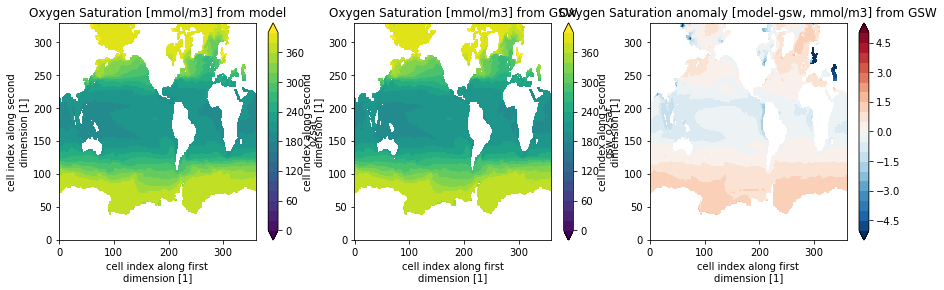

In [18]:
model['gsw_o2sat']=xr.apply_ufunc(gsw.O2sol,models.gsw_as, modelt.gsw_ct, model.lev, models.longitude, models.latitude, dask='allowed')*1.0245e-3
#model['gsw_o2sat']=xr.apply_ufunc(gsw.O2sol_SP_pt,models.so.isel(time=-1), modelt.thetao.isel(time=-1), dask='allowed')*1.0245e-3
# ValueError: applied function returned data with unexpected number of dimensions: 3 vs 4, for dimensions ('member_id', 'lev', 'j', 'i')

fig, (ax1,ax2,ax3) = plt.subplots(figsize=(15,4),ncols=3,nrows=1)
(model.isel(time=-1).isel(lev=0).o2sat*1e6).plot(ax=ax1,levels=np.arange(0,420,20),extend="both")
ax1.set_title("Oxygen Saturation [mmol/m3] from model")
(model.isel(lev=0).gsw_o2sat*1e3).plot(ax=ax2,levels=np.arange(0,420,20),extend="both")
ax2.set_title("Oxygen Saturation [mmol/m3] from GSW")
oanom=(model.o2sat*1e6-model.gsw_o2sat*1e3)
(oanom.isel(time=-1).isel(lev=0)).plot(ax=ax3,levels=np.arange(-5,5.5,0.5),extend="both")
ax3.set_title("Oxygen Saturation anomaly [model-gsw, mmol/m3] from GSW")
plt.show()